<a href="https://colab.research.google.com/github/fjiolla/bbm92-qkd-simulator/blob/main/BBM92_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit_aer
!pip install matplotlib
!pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import numpy as np
from typing import List, Dict
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

In [ ]:
class BBM92Protocol:
    def __init__(self, num_qubits: int = 36, test_sample_ratio: float = 0.1, time_per_pair: float = 1e-5):
        self.num_qubits = num_qubits
        self.test_sample_ratio = test_sample_ratio
        self.qber_threshold = 0.11
        self.simulator = AerSimulator()
        self.noise_model = None
        self.qber_list = []
        self.time_per_pair = time_per_pair

    def enable_noise(self):
        from qiskit_aer.noise import depolarizing_error
        self.noise_model = NoiseModel()

        # Gate error probabilities
        p1 = 0.005    # 1-qubit gate error rate
        p2 = 0.005    # 2-qubit gate error rate

        # Add depolarizing error to all single-qubit gates
        error_1q = depolarizing_error(p1, 1)
        self.noise_model.add_all_qubit_quantum_error(error_1q, ['h', 'x', 'id'])

        # Add depolarizing error to all two-qubit gates
        error_2q = depolarizing_error(p2, 2)
        self.noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

        self.simulator = AerSimulator(noise_model=self.noise_model)

    def disable_noise(self):
        # Disable noise simulation.
        self.simulator = AerSimulator()
        self.noise_model = None

    def throughput(self, sifted_key_length: int, qber: float) -> float:
      total_transmission_time = self.num_qubits * self.time_per_pair

      if total_transmission_time > 0:
        raw_key_rate = sifted_key_length / (total_transmission_time)
      else:
        raw_key_rate = 0

      return raw_key_rate * (1 - qber)


    def compute_ber(self, alice_bits: List[str], bob_bits: List[str]) -> float:
        # Calculate Bit Error Rate between Alice and Bob's bits.
        if not alice_bits or not bob_bits:
            return 0.0
        return sum(a != b for a, b in zip(alice_bits, bob_bits)) / len(alice_bits)

    def total_atmospheric_loss(self, d_r: float, d_t: float, D: float, L: float, alpha: float) -> float:
        if d_t + D * L == 0:
            return 0  # Avoid division by zero
        alpha = alpha / 1000  # Convert to dB/m
        geometric_loss = (d_r / (d_t + D * L)) ** 2
        atmospheric_loss = np.exp(-alpha * L)  # Beer-Lambert law
        return atmospheric_loss * geometric_loss

    def shannon_entropy(self, qber: float) -> float:
        # Compute binary Shannon entropy h(Q) for given QBER.
        if qber == 0 or qber == 1:
            return 0  # No uncertainty when QBER is 0 or 1
        return -qber * np.log2(qber) - (1 - qber) * np.log2(1 - qber)

    def total_qber(self, r1, q_i, tau_c, T) -> float:
        n = 0.6
        n_c = 0.6
        P_nc = 1e-5
        r2 = r1  # Single event rates
        rc = (n**2) * (n_c**2) * r1  # Coincidence rate corresponding to single event rates

        # Calculated raw key rate (half of detected coincidence rate)
        r_sig = 0.5 * rc * T

        # Calculated external background event rate
        r_bg = P_nc * r1

        # Calculated accidental coincidence rate
        r_a = 0.5 * (r_bg + (T * (r1 - rc))) * (r_bg + (T * (r2 - rc))) * tau_c

        # Calculated QBER using equation (13) from the paper
        QBER = (1 / (r_sig + r_a)) * (q_i * r_sig + 0.5 * r_a)
        return QBER

    def calculate_secret_key_rate(self, v_s, qber, T) -> int:
        if qber < self.qber_threshold:
            f_Q = 1.1
            h_q = self.shannon_entropy(qber)
            SKR = 0.5 * v_s * T * (1 - f_Q * h_q - h_q)
            if SKR < 0:
                SKR = 0
        else:
            SKR = 0.0
        return int(SKR)

    def compute_snr(self) -> float:
        results = self.run_protocol(include_eve=False, include_noise=True)

        final_key_length = results['key_length']
        total_qubits = self.num_qubits
        #Here, qber will be because of noise generated by IBM backend
        noise = results['total_qber']

        # Compute signal power
        P_signal = final_key_length / total_qubits
        # Compute total noise
        P_noise = noise
        if P_noise == 0:
            return 0
        else:
          # Compute SNR
          SNR = P_signal / P_noise
          return SNR

    def generate_entangled_pair(self) -> QuantumCircuit:
        # Generate a Bell state (entangled pair) circuit.
        qr = QuantumRegister(2, 'q')
        cr = ClassicalRegister(2, 'c')
        qc = QuantumCircuit(qr, cr)
        qc.h(0)
        qc.cx(0, 1)
        return qc

    def simulate_eavesdropper(self, qc: QuantumCircuit) -> QuantumCircuit:
        # Simulate an eavesdropper intercepting qubits.
        if np.random.random() < 0.3:
            eve_basis = np.random.choice([0, 1])
            if eve_basis:
                qc.h(0)
            qc.measure(0, 0)
            qc.barrier()

            # Eve's resend
            eve_result = np.random.choice(["0", "1"])
            if eve_result == "1":
                qc.x(0)
            if eve_basis:
                qc.h(0)
        return qc

    def remove_garbage(self, a_bases: List[int], b_bases: List[int], bits: List[str]) -> List[str]:
        # Basis reconciliation: Keeping only bits where Alice and Bob used the same basis.
        return [bit for i, bit in enumerate(bits) if a_bases[i] == b_bases[i]]

    def run_protocol(self, include_eve: bool = False, include_noise: bool = True, shots: int = 200) -> Dict:
        # Execute the BBM92 protocol with optional noise and eavesdropper simulation.
        if include_noise:
            self.enable_noise()
        else:
            self.disable_noise()

        alice_basis = np.random.choice([0, 1], self.num_qubits)
        bob_basis = np.random.choice([0, 1], self.num_qubits)

        circuits = []
        alice_bits = []
        bob_bits = []

        for i in range(self.num_qubits):
            qc = self.generate_entangled_pair()
            if include_eve:
                qc = self.simulate_eavesdropper(qc)
            if alice_basis[i]:
                qc.h(0)
            if bob_basis[i]:
                qc.h(1)
            qc.measure([0, 1], [0, 1])
            circuits.append(qc)

        transpiled_circuits = transpile(circuits, self.simulator)
        results = self.simulator.run(transpiled_circuits, shots=shots).result()

        for i, circuit in enumerate(transpiled_circuits):
            counts = results.get_counts(circuit)
            possible_results = list(counts.keys())
            probabilities = [counts[result]/shots for result in possible_results]
            result = np.random.choice(possible_results, p=probabilities)
            alice_bits.append(result[0])
            bob_bits.append(result[1])

        # Perform basis reconciliation
        sifted_alice = self.remove_garbage(alice_basis, bob_basis, alice_bits)
        sifted_bob = self.remove_garbage(alice_basis, bob_basis, bob_bits)

        # Compute Bit Error Rate (BER)
        BER = self.compute_ber(sifted_alice, sifted_bob)

        # Calculate total atmospheric loss
        atmospheric_loss = self.total_atmospheric_loss(
            d_r=100,  # mm
            d_t=10,   # mm
            D=0.025,  # mrad
            L=5000,  # m
            alpha=0.1  # dB/km
        )
        total_loss = -10 * np.log10(atmospheric_loss)

        # Compute Total QBER (Including various other parameters)
        total_qber = self.total_qber(
            r1=0.64e6,
            q_i=0.043,
            tau_c=2e-9,
            T=total_loss
        )
        total_qber += BER

        # Calculate secret key rate (also known as Throughput (bits/sec))
        SKR = self.calculate_secret_key_rate(v_s=0.64e6, qber=BER, T=atmospheric_loss)

        # Calculate key generation rate
        Throughput = self.throughput(len(sifted_alice), total_qber)

        return {
            'alice_basis': alice_basis,
            'bob_basis': bob_basis,
            'alice_bits': alice_bits,
            'bob_bits': bob_bits,
            'sifted_alice': sifted_alice,
            'sifted_bob': sifted_bob,
            'qber': BER,
            'total_qber': total_qber,
            'eavesdropping_detected': BER > self.qber_threshold,
            'key_length': len(sifted_alice),
            'secret_key_rate': SKR,
            'throughput': Throughput,
            'total_atmospheric_loss': total_loss,
            'circuits': circuits
        }

In [ ]:

#Printing values
if __name__ == "__main__":
    protocol = BBM92Protocol(num_qubits=34, time_per_pair = 1e-5)

    # Run the protocol with/without noise and eavesdropper
    results = protocol.run_protocol(include_eve=False, include_noise=False, shots = 200)

    #Calculate signal to noise ratio
    SNR = protocol.compute_snr()


    print(f"Final key length: {results['key_length']}")
    print(f"Secret key rate: {results['secret_key_rate']}")
    print(f"Throughput: {results['throughput']:.3f}")
    print(f"Bit Error Rate: {results['qber']:.3f}")
    print(f"Total QBER: {results['total_qber']:.3f}")
    print(f"Total Atmospheric Loss: {results['total_atmospheric_loss']:.3f}")
    print(f"Eavesdropping detected: {results['eavesdropping_detected']}")
    print(f"SNR: {SNR:.3f}")


Final key length: 13
Secret key rate: 106496
Throughput: 35988.021
Bit Error Rate: 0.000
Total QBER: 0.059
Total Atmospheric Loss: 4.778
Eavesdropping detected: False
SNR: 3.880


In [ ]:
class BBM92ProtocolWithPlots(BBM92Protocol):

    def run_simulations_at_distance(self, distance: float, include_eve: bool, include_noise: bool) -> Dict:
        results = self.run_protocol(include_eve=include_eve, include_noise=include_noise, shots=10000)


        atmospheric_loss = self.total_atmospheric_loss(
            d_r=100,    # mm (receiver aperture)
            d_t=10,     # mm (transmitter aperture)
            D=0.025,    # mrad (beam divergence)
            L=distance, # m (variable distance)
            alpha=0.1    # dB/km (attenuation coefficient)
        )
        total_loss = -10 * np.log10(atmospheric_loss)


        total_qber = self.total_qber(
            r1=0.64e6,    # Single photon rate
            q_i=0.043,    # Intrinsic error
            tau_c=2e-9,
            T=total_loss  # Transmission efficiency
        )


        SKR = self.calculate_secret_key_rate(
            v_s=0.64e6,       # Source rate
            qber=results['qber'],  # Total QBER
            T=atmospheric_loss # Transmission efficiency
        )

        results.update({
            'total_qber': total_qber,
            'secret_key_rate': SKR,
            'total_atmospheric_loss': total_loss,
            'distance': distance
        })

        return results
    """
    def plot_total_qber_vs_channel_loss(self, detector_efficiencies: List[float]):
        #Plot Total QBER vs Channel Loss for different detector efficiencies.
        channel_losses = np.linspace(0, 30, 20)

        qber_results = {efficiency: [] for efficiency in detector_efficiencies}

        for efficiency in detector_efficiencies:
            for loss in channel_losses:
                atmospheric_loss = 10 ** (-loss / 10)

                # Run multiple trials for each point to get average behavior
                trials_qber = []
                for _ in range(5):
                    results = self.run_protocol(include_eve=True, include_noise=False)
                    trials_qber.append(results['total_qber'])
                qber_results[efficiency].append(np.mean(trials_qber)*100)

        plt.figure(figsize=(10, 6))
        for efficiency, qber_values in qber_results.items():
            plt.plot(channel_losses, qber_values,
                    marker='o', markersize=4,
                    label=f'η = {efficiency:.2f}')

        plt.xlabel('Channel Loss (dB)')
        plt.ylabel('QBER(%)')
        plt.title('Total QBER vs Channel Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, max([max(v) for v in qber_results.values()]) * 1.1)
        plt.show()


    def plot_atmospheric_loss_vs_distance(self):
        distances = np.linspace(1, 5000, 100)  # 1km to 50km

        # Calculate atmospheric loss for each distance
        losses = []
        for distance in distances:
            loss = self.total_atmospheric_loss(
                d_r=100,  # mm
                d_t=10,   # mm
                D=0.025,  # mrad
                L=distance,  # m (variable)
                alpha=0.1  # dB/km
            )
            losses.append(-10 * np.log10(loss))


        plt.figure(figsize=(10, 6))
        plt.plot(distances/1000, losses, 'g-')

        plt.xlabel('Distance (km)')
        plt.ylabel('Channel Loss (dB)')
        plt.title('Channel Loss vs Distance')
        plt.grid(True)
        plt.show()

        return distances/1000, losses



    def plot_skr_vs_channel_loss(self, detector_efficiencies: List[float]):
        channel_losses = np.linspace(0, 30, 20)  # Channel loss in dB
        skr_results = {efficiency: [] for efficiency in detector_efficiencies}

        num_trials = 10

        for efficiency in detector_efficiencies:
            for loss in channel_losses:
                atmospheric_loss = 10 ** (-loss / 10)

                # Run multiple trials for each point to get average behavior
                trials_skr = []
                for _ in range(num_trials):
                    results = self.run_protocol(include_eve=True, include_noise=False)

                    adjusted_skr = self.calculate_secret_key_rate(
                    v_s=0.64e6,
                    qber=results['total_qber'],
                    T=atmospheric_loss
                )

                    #Non-negative values
                    trials_skr.append(max(0, adjusted_skr))

                skr_results[efficiency].append(np.mean(trials_skr))

        plt.figure(figsize=(10, 6))
        colors = ['blue', 'orange', 'green']

        for i, (efficiency, skr_values) in enumerate(skr_results.items()):
            plt.plot(channel_losses, skr_values,
               color=colors[i], marker='o', markersize=5, linewidth=2,
               label=f'η = {efficiency:.2f}')

        plt.xlabel('Channel Loss (dB)', fontsize=12)
        plt.ylabel('Secret Key Rate (bits/sec)', fontsize=12)
        plt.title('Secret Key Rate vs Channel Loss', fontsize=14)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.ylim(bottom=0)

        plt.show()
    """

    def plot_skr_vs_distance(self):
        distances = np.linspace(5000, 30000, 30)  # in meters

        distances_km = []
        skr_no_eve = []

        # Run simulations
        for distance in distances:
            # No Eve
            results_no_eve = self.run_simulations_at_distance(
            distance=distance,
            include_eve=False,
            include_noise=False
        )

            # Store results
            distances_km.append(distance/1000)  # Convert to km for plotting
            skr_no_eve.append(max(0, results_no_eve['secret_key_rate']))  # Ensure non-negative

        plt.figure(figsize=(10, 6))
        plt.plot(distances_km, skr_no_eve, 'b-o', linewidth=2)

        plt.xlabel('Distance (km)', fontsize=12)
        plt.ylabel('Secret Key Rate (bits/s)', fontsize=12)
        plt.title('Secret Key Rate vs Distance (km) ', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.show()

        return distances_km, skr_no_eve

    def plot_qber_vs_distance(self):
      distances = np.linspace(1000, 50000, 100)  # in meters
      distances_km = distances / 1000  # Convert to km for plotting
      qber_values = []

      for distance in distances:
        atmospheric_loss = self.total_atmospheric_loss(
            d_r=100,    # mm (receiver aperture)
            d_t=10,     # mm (transmitter aperture)
            D=0.025,    # mrad (beam divergence)
            L=distance, # m (variable distance)
            alpha=0.1    # dB/km (attenuation coefficient)
        )
        total_loss = -10 * np.log10(atmospheric_loss)

        # Run protocol with Eve and noise disabled
        results = self.run_protocol(include_eve=False, include_noise=False)

        # Calculate total QBER
        total_qber = self.total_qber(
            r1=0.64e6 * 0.6,  # Single photon rate with efficiency 0.6
            q_i=0.043,        # Intrinsic error
            tau_c=2e-9,       # Coincidence window
            T=total_loss # Transmission efficiency
        )

        total_qber += results['qber']
        qber_values.append(total_qber * 100)  # Convert to percentage

    # Create the plot
      plt.figure(figsize=(10, 6))
      plt.plot(distances_km, qber_values, 'r-', linewidth=1.5)
      plt.xlabel('Distance (km)', fontsize=12)
      plt.ylabel('QBER (%)', fontsize=12)
      plt.title('QBER vs Distance (No Eve, No Noise)', fontsize=14)
      plt.grid(True, alpha=0.3)
      plt.ylim(0, max(qber_values) * 1.1)
      plt.show()

      return distances_km, qber_values


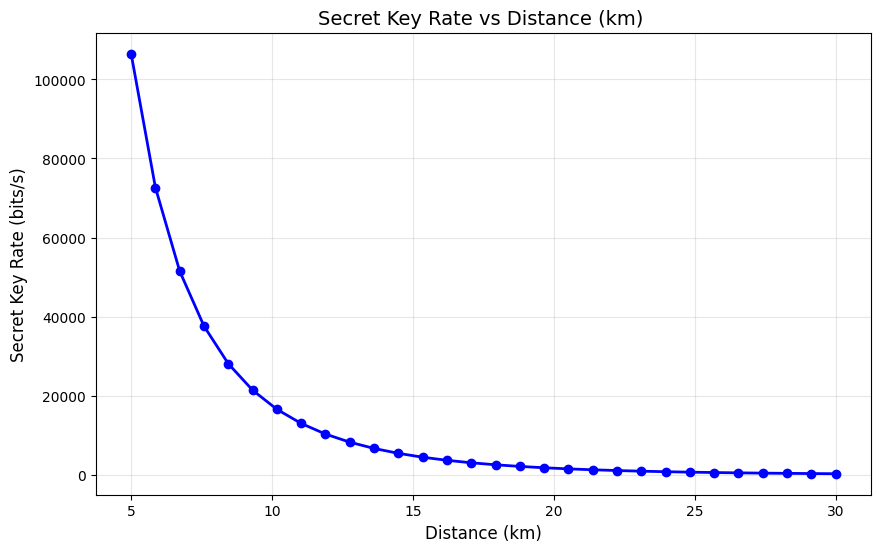

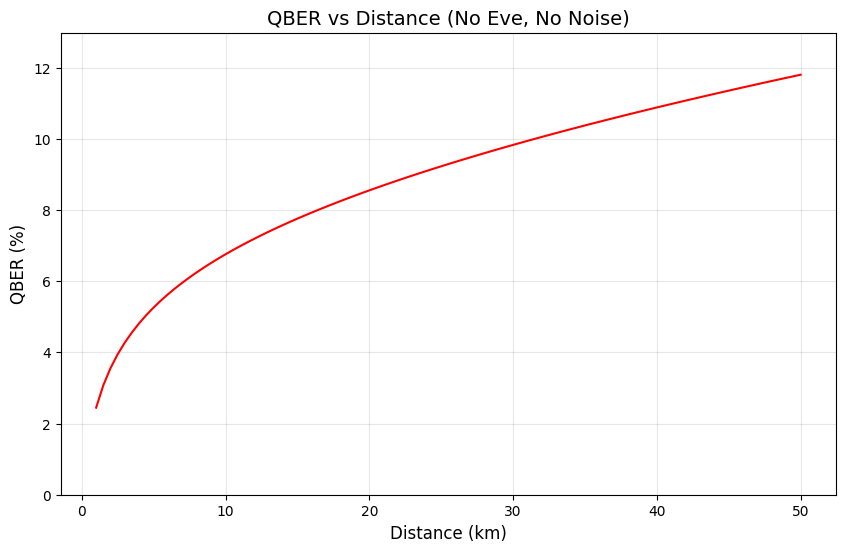

In [ ]:
if __name__ == "__main__":
    protocol = BBM92ProtocolWithPlots(num_qubits=34)

    #protocol.plot_total_qber_vs_channel_loss(detector_efficiencies=[0.6, 0.8])
    print("\n" * 3)
    protocol.plot_skr_vs_distance()
    #protocol.plot_atmospheric_loss_vs_distance()
    print("\n" * 3)
    protocol.plot_qber_vs_distance()
    #protocol.plot_skr_vs_channel_loss(detector_efficiencies=[0.4, 0.6, 0.8])

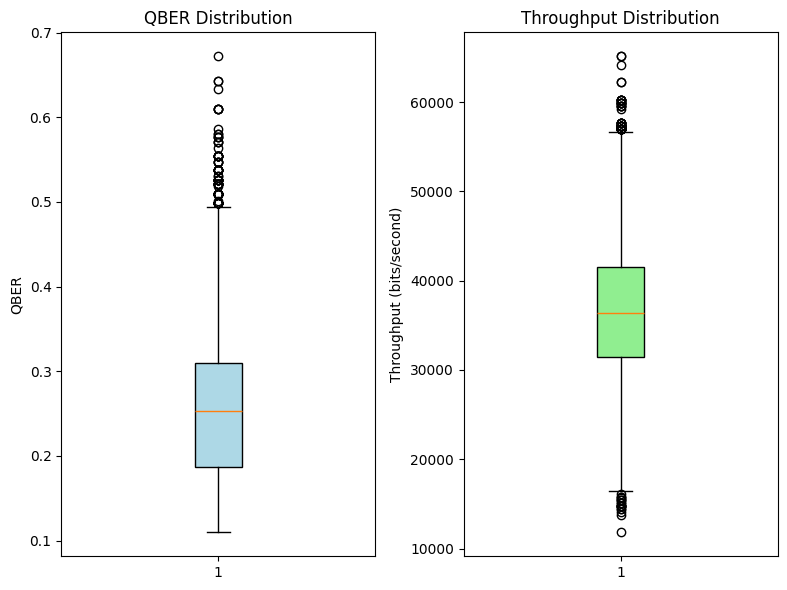

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    protocol = BBM92Protocol(num_qubits=34)

    # Lists to store results from multiple runs
    qber_list = []
    throughput_list = []

    n_iterations = 10000
    count=0

    # Collect data with Eve
    for _ in range(n_iterations):
        results = protocol.run_protocol(include_eve=True, include_noise=False, shots=10000)
        qber_list.append(results['total_qber'])
        throughput_list.append(results['throughput'])



    def plot_boxplots(qber_list: List[float], skr_list: List[float]):
      plt.figure(figsize=(12, 6))

      #QBER Boxplot
      plt.subplot(1, 3, 1)
      plt.boxplot(qber_list, vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
      plt.title("QBER Distribution")
      plt.ylabel("QBER")

      # Bitrate Boxplot
      plt.subplot(1, 3, 2)
      plt.boxplot(throughput_list, vert=True, patch_artist=True, boxprops=dict(facecolor="lightgreen"))
      plt.title("Throughput Distribution")
      plt.ylabel("Throughput (bits/second)")

      plt.tight_layout()
      plt.show()

    plot_boxplots(qber_list, throughput_list)

In [ ]:
# Save QBER data
with open("qber_data.txt", "w") as qber_file:
    for qber in qber_list:
        qber_file.write(f"{qber}\n")

print("QBER data saved to qber_data.txt")

# Save Throughput (SKR) data
with open("throughput_data.txt", "w") as skr_file:
    for skr in throughput_list:
        skr_file.write(f"{skr}\n")

print("Throughput data saved to skr_data.txt")


QBER data saved to qber_data.txt
Throughput data saved to skr_data.txt


<ipython-input-132-f46bee46294a>:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bbm92_data, mdi_data], labels=["BBM92", "MDI"])


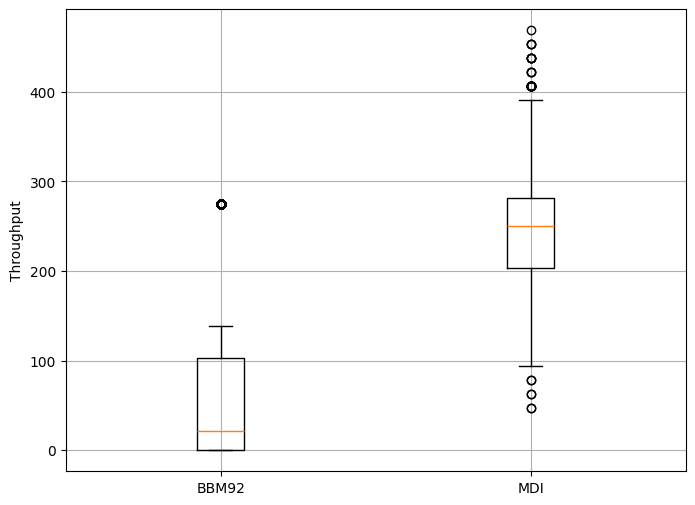

In [ ]:
import matplotlib.pyplot as plt

# Read throughput values from BBM92 file
with open("throughput_data.txt", "r") as f1:
    bbm92_data = [float(line.strip()) for line in f1]

# Read throughput values from MDI file
with open("throughput_MDI_1.txt", "r") as f2:
    mdi_data = [float(line.strip()) for line in f2]

# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([bbm92_data, mdi_data], labels=["BBM92", "MDI"])

# Add title and labels
plt.ylabel("Throughput")
plt.grid(True)

# Show plot
plt.show()


<ipython-input-131-458e068aabd4>:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bbm92_data, mdi_data], labels=["BBM92", "MDI"])


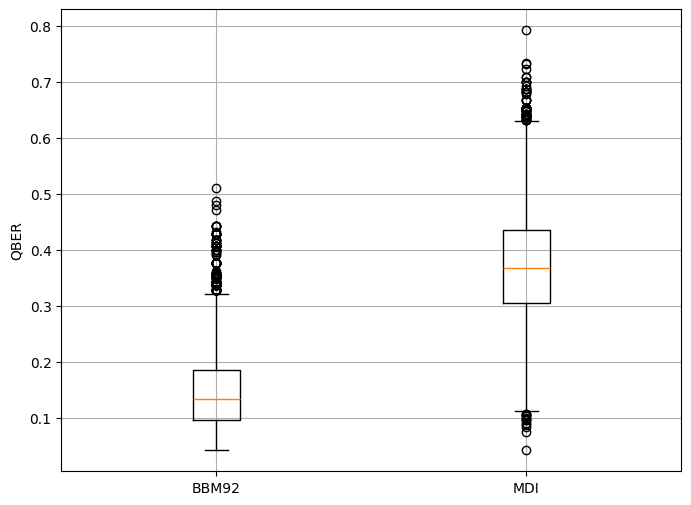

In [ ]:
import matplotlib.pyplot as plt

# Read throughput values from BBM92 file
with open("qber_data.txt", "r") as f1:
    bbm92_data = [float(line.strip()) for line in f1]

# Read throughput values from MDI file
with open("qber_MDI.txt", "r") as f2:
    mdi_data = [float(line.strip()) for line in f2]

# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot([bbm92_data, mdi_data], labels=["BBM92", "MDI"])

plt.ylabel("QBER")
plt.grid(True)

# Show plot
plt.show()
